**Chapter 13 – Loading and Preprocessing Data with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 13._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Datasets

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

Equivalently:

In [3]:
dataset = tf.data.Dataset.range(10)

In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [5]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [6]:
dataset = dataset.map(lambda x: x * 2)

In [7]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [8]:
dataset = dataset.apply(tf.data.experimental.unbatch())

In [9]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10

In [10]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [11]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 3 4 2 1 5 8], shape=(7,), dtype=int64)
tf.Tensor([6 9 7 2 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([6 0 7 9 0 1 2], shape=(7,), dtype=int64)
tf.Tensor([8 4 5 5 3 8 9], shape=(7,), dtype=int64)
tf.Tensor([7 6], shape=(2,), dtype=int64)


## Split the California dataset to multiple CSV files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [13]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [14]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [15]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Or in text mode:

In [16]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [17]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

## Building an Input Pipeline

In [18]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [19]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [20]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [21]:
for line in dataset.take(5):
    print(line.numpy())

b'4.2083,44.0,5.323204419889502,0.9171270718232044,846.0,2.3370165745856353,37.47,-122.2,2.782'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'


Notice that field 4 is interpreted as a string.

In [22]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: id=245, shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: id=246, shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: id=247, shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: id=248, shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: id=249, shape=(), dtype=float32, numpy=5.0>]

Notice that all missing fields are replaced with their default value, when provided:

In [23]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: id=259, shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: id=260, shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: id=261, shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: id=262, shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: id=263, shape=(), dtype=float32, numpy=5.0>]

The 5th field is compulsory (since we provided `tf.constant([])` as the "default value"), so we get an exception if we do not provide it:

In [24]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


The number of fields should match exactly the number of fields in the `record_defaults`:

In [25]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [26]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [27]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: id=307, shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: id=308, shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [28]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [29]:
train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.1309323   0.5834586  -1.1141092  -0.0205977   0.4861637   0.05622157
  -0.72447133  0.63188833]
 [ 1.9003258  -0.998705    0.6331733  -0.03226789  0.05084941 -0.28879014
   1.0229574  -1.2872185 ]
 [-0.08566543 -1.6315705   0.04572354 -0.16350564  0.18226504  0.09547261
  -0.92123175  0.65187943]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.219]
 [3.702]
 [2.875]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.92681414 -1.0778131   0.194918   -0.2745752  -0.02215928  0.13869788
   1.2525111  -1.5520943 ]
 [ 0.12441459 -2.0271113  -0.0920579  -0.17962678 -0.38263968  0.11107364
  -1.3007004   1.9912548 ]
 [-0.10782045  1.8491895  -0.01604682  0.04678809 -0.33609664 -0.2658364
   0.9807942  -1.4471437 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.724]
 [0.832]
 [3.118]], shape=(3, 1), dtype=float32)



In [30]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [31]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [32]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [33]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 2.4158 - val_loss: 0.9218
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.7571 - val_loss: 0.6992
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6767 - val_loss: 0.6532
Epoch 4/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6406 - val_loss: 0.6751
Epoch 5/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6012 - val_loss: 0.5904
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5792 - val_loss: 0.6392
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5531 - val_loss: 0.5686
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5050 - val_loss: 0.5086
Epoch 9/10
362/362 [==============================] - 1s 2ms/step - loss: 0.5039 - val_loss: 0.4825
Epoch 10/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4930 - val_loss: 0.4761

In [34]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 1ms/step - loss: 0.4804


0.4803512151937307

In [35]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[2.5751495],
       [2.1568842],
       [2.019339 ],
       ...,
       [3.553556 ],
       [2.2041245],
       [2.366016 ]], dtype=float32)

In [36]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [37]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [38]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


Here is a short description of each method in the `Dataset` class:

In [39]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating given dataset with this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()         Maps `map_func` across this dataset, and interleaves the results.
● list_files()         A dataset of all files matching one or more glob patterns.
● map()                Maps `map_func` across the elements of this dataset.
● options()   

## The `TFRecord` binary format

A TFRecord file is just a list of binary records. You can create one using a `tf.io.TFRecordWriter`:

In [40]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a `tf.data.TFRecordDataset`:

In [41]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [42]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [43]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [44]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Intro to Protocol Buffers

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [45]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [46]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [47]:
!ls person*

person.desc   person.proto  person_pb2.py


In [48]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [49]:
person.name  # read a field

'Al'

In [50]:
person.name = "Alice"  # modify a field

In [51]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [52]:
person.email.append("c@d.com")  # add an email address

In [53]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [54]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [55]:
person == person2  # now they are equal

True

#### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [56]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: id=12, shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: id=13, shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: id=14, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

### TensorFlow Protobufs

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [57]:
# WARNING: there's currently a bug preventing "from tensorflow.train import X"
#          so we work around it by writing "X = tf.train.X"
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [58]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [59]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x102a2acc0>,
 'id': <tf.Tensor: id=535953, shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: id=535954, shape=(), dtype=string, numpy=b'Alice'>}

In [60]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x102a2acc0>,
 'id': <tf.Tensor: id=535953, shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: id=535954, shape=(), dtype=string, numpy=b'Alice'>}

In [61]:
parsed_example["emails"].values[0]

<tf.Tensor: id=535962, shape=(), dtype=string, numpy=b'a@b.com'>

In [62]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: id=535965, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [63]:
parsed_example["emails"].values

<tf.Tensor: id=535951, shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

### Putting Images in TFRecords

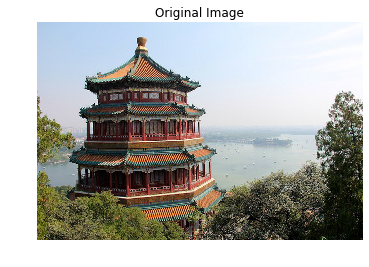

In [64]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [65]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

In [66]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

In [67]:
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

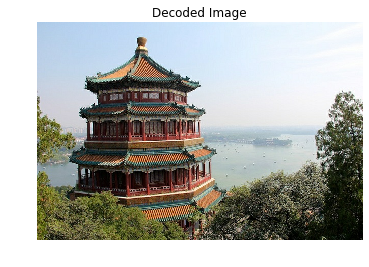

In [68]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

### Putting Tensors and Sparse Tensors in TFRecords

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [69]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: id=536000, shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [70]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: id=536002, shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [71]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: id=536004, shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [72]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [73]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [74]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x129697b70>}

## Handling Sequential Data Using `SequenceExample`

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

In [75]:
# WARNING: there's currently a bug preventing "from tensorflow.train import X"
#          so we work around it by writing "X = tf.train.X"
#from tensorflow.train import FeatureList, FeatureLists, SequenceExample
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [76]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [77]:
serialized_sequence_example = sequence_example.SerializeToString()

In [78]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [79]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x134ff6c88>,
 'author_id': <tf.Tensor: id=536050, shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: id=536051, shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [80]:
parsed_context["title"].values

<tf.Tensor: id=536048, shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [81]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x134ff6f98>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x130e23390>}

In [82]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# The Features API

Let's use the variant of the California housing dataset that we used in Chapter 2, since it contains categorical features and missing values:

In [83]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [84]:
fetch_housing_data()

In [85]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [86]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [87]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [88]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [89]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [90]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [91]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [92]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [93]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [94]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [95]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [96]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [97]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

### Using Feature Columns for Parsing

In [98]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [99]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [100]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [101]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

**Warning**: the `DenseFeatures` layer currently does not work with the Functional API, see [TF issue #27416](https://github.com/tensorflow/tensorflow/issues/27416). Hopefully this will be resolved before the final release of TF 2.0.

In [102]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
362/362 [==============================] - 1s 3ms/step - loss: 5.0263 - accuracy: 0.0017
Epoch 2/5
362/362 [==============================] - 1s 2ms/step - loss: 2.1655 - accuracy: 0.0036
Epoch 3/5
362/362 [==============================] - 1s 2ms/step - loss: 1.5688 - accuracy: 0.0028
Epoch 4/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3550 - accuracy: 0.0022
Epoch 5/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3466 - accuracy: 0.0035


In [103]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

W0314 09:13:03.443593 140735783818112 deprecation.py:323] From /Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:3038: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0314 09:13:03.451946 140735783818112 deprecation.py:323] From /Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


<tf.Tensor: id=551231, shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.30818242, -0.40305588],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -0.7438171 ,  0.19444346],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.7438171 ,  0.19444346]], dtype=float32)>

# TF Transform

In [104]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

TF Transform is not installed. Try running: pip3 install -U tensorflow-transform


# TensorFlow Datasets

In [105]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [106]:
print(tfds.list_builders())

['bair_robot_pushing_small', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'coco2014', 'colorectal_histology', 'colorectal_histology_large', 'diabetic_retinopathy_detection', 'dummy_dataset_shared_generator', 'dummy_mnist', 'fashion_mnist', 'flores_translate_neen', 'flores_translate_sien', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imdb_reviews', 'kmnist', 'lm1b', 'lsun', 'mnist', 'moving_mnist', 'multi_nli', 'nsynth', 'omniglot', 'open_images_v4', 'quickdraw_bitmap', 'rock_paper_scissors', 'squad', 'starcraft_video', 'svhn_cropped', 'ted_hrlr_translate', 'ted_multi_translate', 'tf_flowers', 'titanic', 'wmt_translate_ende', 'wmt_translate_enfr']


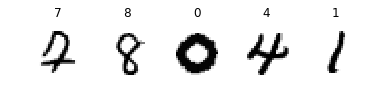

In [107]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [108]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[1 3 8 6 0 7 7 9 2 7 3 7 6 0 4 9 8 1 5 6 0 8 0 3 7 2 6 3 3 5 5 4]


In [109]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 31.4932 - accuracy: 0.8428
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 26.2404 - accuracy: 0.8693
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 24.9957 - accuracy: 0.8743
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 24.0785 - accuracy: 0.8780
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 23.8285 - accuracy: 0.8782


In [110]:
try:
    datasets = tfds.load("imagenet2012", split=["train", "test"])
except AssertionError as ex:
    print(ex)

# TensorFlow Hub

In [111]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [112]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [113]:
embeddings

<tf.Tensor: id=665258, shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-